## An analysis of A/B test results of web page variations

This data analysis examines website traffic data from 2 web page variations to try to determine which page (if any) performs better with respect to conversions.

## Table of Contents
- [Introduction](#intro)
- [Part I - Initial investigation](#initial)
- [Part II - Manual A/B Test](#probability)
- [Part III - Built-in function A/B Test](#ab_test)
- [Part IV - Regression based A/B Test](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

In this project, I will be working to understand the results of an A/B test run by an e-commerce website. This test concerns a particular web page (old version) and a new version of the page (new design etc). My goal is to help the company understand if they should implement the new page, or keep the old page.

I will be using 3 different approaches to perform the A/B test:

* Manually calculated A/B test
* A/B test using bulit-in library functions
* A/B test using a regression based approach

I will then compare and contrast the results of each, and arrive at a final reccomendation as to if the company should stick with the old page, or implement the new page.

<a id='initial'></a>
### Part I - Initial investigation

Let's import our required libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Lets set a random seed so results are reproducable
random.seed(42)

Now we read in the dataset of our website traffic observations for the two page variants and take a look at the top few rows:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The dataset has a range of columns/variables, the group column indicates for which page variant that observation was for: control indicates the old page varient, treatment indicates the new page variant. The converted column indicates if the user converted or not - 1 = converted, 0 = did not convert. (We will leave out the specifics of what conversion actually means but assume it to be some common metric e.g. clicked through to a particular link on that page).

#### Data wrangling/cleaning

Lets find the number of rows in the dataset.

In [4]:
total_rows = df.shape[0]
print(total_rows)

294478


Lets find the number of unique users in the dataset.

In [5]:
unique_users_count = df.user_id.nunique()
print(unique_users_count)

290584


What is the proportion of users converted for both pages summed up together?

In [6]:
users_converted = df.converted.sum()
prop_users_converted = users_converted / total_rows
print(prop_users_converted)

0.11965919355605512


So we need to check that for all observations regarding the group & landing_page columns:

* 'control' is always associated with 'old_page' 
* 'treatment' is always associated with 'new_page'

Lets check the number of times the `new_page` and `treatment` don't line up.

In [7]:
no_newpage_treatment = df[(((df.group == 'treatment') & (df.landing_page != 'new_page')) | ((df.group != 'treatment') & (df.landing_page == 'new_page')))]
no_newpage_treatment.shape[0]

3893

Ok so we have a few, we will need to think about how we deal with these.

Lets also check if any of the rows have missing values?

In [8]:
no_newpage_treatment.isnull().sum().sum()

0

Ok thats great at least no missing values!

So for the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this observation truly received the new or old page.  

So for our tests to be based on the most reliable data, we will remove these rows before we do our analysis.

In [9]:
df2 = df[(((df.group == 'treatment') & (df.landing_page == 'new_page')) | ((df.group == 'control') & (df.landing_page == 'old_page')))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Ok lets see how many unique **user_id**s are in **df2**?

In [11]:
unique_users_count2 = df2.user_id.nunique()
print(unique_users_count2)

290584


Lets check to see if we have any duplicated users

In [12]:
duplicates = df2[df2.duplicated(['user_id'])]
duplicates.head()

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Ok so we seem to have duplicated users.

What is the row information for the repeat **user_id**? 

In [13]:
df2[(df2.user_id == 773192)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Ok apart from the different timestamp, both of these observations are essentially the same with respect to group, landing_page & conversion.

Lets remove **one** of the rows with a duplicate **user_id**.

In [14]:
df2 = df2.drop_duplicates(subset=['user_id'], keep='first')
df2[(df2.user_id == 773192)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


#### Initial Analysis

Ok now that the data wrangling/cleaning is done - lets re-calculate the probability of an individual converting regardless of the page they receive:

In [15]:
total_rows2 = df2.shape[0]
users_converted2 = df2.converted.sum()
prob_user_conversion = users_converted2 / total_rows2
print(prob_user_conversion)

0.11959708724499628


Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control = df2[df2['group'] == 'control']
control_converted = control.converted.sum()
prob_control_conversion = control_converted / control.shape[0]
print(prob_control_conversion)

0.1203863045004612


Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment = df2[df2['group'] == 'treatment']
treatment_converted = treatment.converted.sum()
prob_treatment_conversion = treatment_converted / treatment.shape[0]
print(prob_treatment_conversion)

0.11880806551510564


For our observations of the traffic to each of the two pages, lets calculate the observed difference in conversion between the two page variants.

In [18]:
# Diff as new - old page
obs_diff_conversion = prob_treatment_conversion - prob_control_conversion
print(obs_diff_conversion)

-0.0015782389853555567


And what is the probability that an individual received the new page v the old page?

In [19]:
got_new_page = df2[df2['landing_page'] == 'new_page']
prob_new_page = got_new_page.shape[0] / df2.shape[0]
print(prob_new_page)

0.5000619442226688


**Given that the probablity of conversion of both pages is so close, this suggests there is  NOT much evidence that one page leads to more conversions than the other, however we would want to do further statistical tests to be more sure of this.**

<a id='probability'></a>
### Part II - Manual A/B Test

Lets set up our null and alternate hypotheses for the test. 

So we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. So given **$p_{old}$** is the conversion rate of the old page, and **$p_{new}$** is the conversion rate of the new page, we will assume the following hypotheses:

$$H_0: p_{old} - p_{new} >= 0$$

$$H_1: p_{old} - p_{new} < 0$$

Therefore we will assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Then we will create a sampling distribution to simulate the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null using bootstrapping. 10,000 iterations should be sufficient for the law of large numbers & the central limit theorem to apply i.e. for the distribution to be normally distributed, and to enable it to better estimate the actual difference in conversion between the pages for all website users i.e. our parameter from our confidence interval. <br><br>

After simulating observations that would possible be at the top edge of the null, we will then compare this to the actual observed difference, and calculate a p-value to determine how likely our observation came from the null hypothesis. In other words, our p-value will help us determine if there is a statisically significant difference in the conversion rate of our two pages i.e. if the new page is **really** better than the old page.

Lets recap what is the **convert rate** for $p_{new}$ under the null? 

In [20]:
prop_users_converted

0.11965919355605512

And what is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
prop_users_converted

0.11965919355605512

Lets define $n_{new}$, the number of observations that should be simulated for the new page under the null:

In [22]:
n_new = treatment.shape[0]
print(n_new)

145310


And lets define $n_{old}$, the number of observations that should be simulated for the old page under the null:

In [23]:
n_old = control.shape[0]
print(n_old)

145274


As a test to see what values we can expect under the simulation, lets simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, prop_users_converted, n_new)

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, prop_users_converted, n_old)

So what type of values can we expect for the difference in conversion under our simulation?

In [26]:
p_new = new_page_converted.sum() / new_page_converted.shape[0]
p_old = old_page_converted.sum() / old_page_converted.shape[0]
p_new - p_old

-0.000745556951710899

Lets see how this compares with the observed difference:

In [27]:
obs_diff_conversion

-0.0015782389853555567

Ok these seem comparable, lets go ahead with the full simulation.

We will now create a sampling distribution for our statistic (the difference in conversion rate between old & new pages) under the null hypothesis.

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process above.  Store all 10,000 values in **p_diffs**.

In [29]:
# Use bootstrap sampling to create 10,000 sample differences using the observed probability of conversion
# for both pages combined i.e. under the null hypothesis, and then calculate 10,000 differences for each of these
# (Use numpy built-in rather than for loop for more efficiency)
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
# Diff as new - old page (keep same way of calculating difference as observed diff)
p_diffs = new_converted_simulation - old_converted_simulation

Plot a histogram of the **p_diffs** - our sampling distribution of the diffence in conversion under the null hypothesis:

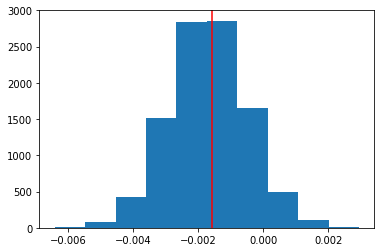

In [74]:
plt.hist(p_diffs)
# Also plot the actual observed difference in conversion in our sample
plt.axvline(x=obs_diff_conversion, color = 'red'); 

So it seems like our observed difference is well within the bulk of the sampling distribution of the simulated differences under the null hypothesis - i.e. it seems like our observed difference could easily have occured under the null hypothesis.[mention distribution does not include zero but very small]

Lets calculate a p value to illustrate this i.e. what proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [75]:
p_value = (p_diffs > obs_diff_conversion).mean()
print(p_value)

0.46


**So our p value is the probability of observing our statistic (in this case the observed difference in conversion) given the null hypothesis is true. So if p is large, this means that the null is more likely to have generated our observed statistic ie that the null hypothesis is true. If p is small, this means that the null less likely to have generated our observed statistic. Also for the alternate hypothesis to be supported, we need a p value smaller than the type 1 error rate (alpha) of 5% (0.05), for a 95% confidence interval. Given our p value is larger than the alpha - therefore we failed to reject the null hypothesis. For our pages what this means is there is no significant statistical difference between the conversion rates of the old and new pages based on this evidence.**

<a id='ab_test'></a>

### Part III - Built-in function A/B Test

As an alternative to our manually calculated test previously, more commonly we would use a built-in library function to achieve similar results more conveniently.  

We will use the same null and alternate hypothesis declared in the manual approach i.e.

$$H_0: p_{old} - p_{new} >= 0$$

$$H_1: p_{old} - p_{new} < 0$$

Lets import new libraries needed for this built-in test, and segment our original observations by page type to feed directly into the test function.

In [76]:
import statsmodels.api as sm

convert_old = control_converted
convert_new = treatment_converted
n_old = control.shape[0]
n_new = treatment.shape[0]

Lets now use `stats.proportions_ztest` to compute our test statistic and p-value.

In [77]:
# Function defaults to 2-sided test, but we want a 1-sided test ie where
# alternative hypothesis is new_page > old_page therefore we must
# pass extra parameter to function to ensure 1-sided test
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score)
print(p_value)

1.3109241984234394
0.9050583127590245


**So the z-score is a measure of the significance of the test, and given we are aiming for a 5% error rate this will mean a z-score less than -1.96 or greater than 1.96 will be signficiant. So the z-score is actually within these bounds, and while the p-value is a bit different from my manually computed in the previous section, it is still large enough to indicate that we failed to reject the null hypothesis.**

<a id='regression'></a>
### Part IV - A regression approach

So we can also do an A/B test by performing regression.

Given the variable we want to predict for each page has two states (i.e. converted: 1 & 0), logistic regression would be a relevant regression technique we can use in this case.

To convert this into a regression problem we need to think about what we are trying to do a little differently. In regression terms, we want to see how well we can fit a regression model to see if there is a significant difference in conversion based on which page a customer receives.

Let's import the new library needed and prepare the data:

In [78]:
import statsmodels.api as sm
# We need to add an intercept column for the regression model base case
df2['intercept'] = 1
# Lets also convert the group column (page type) column into a dummy (0/1) variable 
# so our regression model can use it
df2[['old_page', 'new_page']] = pd.get_dummies(df2['group'])
# We don't need one of these new columns because the information is implicit in the other and
# so the dropped column (old_page) will act as the baseline of the model 
df2 = df2.drop(['old_page'], axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


So as well as the intercept, we now have a new dummy variable column 'ab_page' which is 0 if its the old page, and 1 if the new page.

Lets now use **statsmodels** to import our regression model.  

Instantiate the model, and fit the model using the two columns created to see if the new page is significant in helping us predict conversions (compared to the baseline i.e. the old page).

In [79]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','new_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Lets see a summary of our created model:

In [80]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 26 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        15:50:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Let's also calculate the adjusted correlation coefficient for new_page:

In [81]:
1/np.exp(-0.0150)

1.015113064615719

So our correlation coefficient indicates that for every 1 unit decrease on the new page, conversion is 1.01 times as likely as the old page - holding all else constant. In other words - there is very little difference in the conversion rate between the two pages.

The p value is 0.19 - indicating that the new page is not significant in helping to predict conversion compareed to the old page. But is this a different p value compared to the p value calculated in the manual and built-in appoaches previously? (in terms of what the p value actually means)

In the manual and built-in A/B tests, the null and alternative hypotheses were the following:

$$H_0: p_{old} - p_{new} >= 0$$

$$H_1: p_{old} - p_{new} < 0$$
 
The p values in these cases was the probability of observing our statistic given the null hypothesis, ie the probability that the conversion rate of the old page is equal to OR BETTER THAN the new page. 

When using logistic regression, it would be more appropriate to use the following null & alternate hypotheses:

$$H_0: p_{old} - p_{new} = 0$$

$$H_1: p_{old} - p_{new} \neq 0$$
 
These are different hypotheses. Given the p value is the probability of observing our statistic given the null hypothesis, in this case the p value (of the new page) represents the probability that if the new page is used, that the user will convert, or alternatively, if using the new page is significant in predicting conversion compared to the baseline (the old page). These are different probabilities, and explains why the meaning as well as values of p values are different. Here the null hypthothesis is: both pages convert with an equal conversion rate. The p value of 0.19 for the new page indicates that there is no significant difference in the conversion rate of the new page i.e. that the null hypothesis is true.

Adding more predictor variables may help us gain a more accurate prediction. However there are disadvantages to this that need to be considered, for example if some of our predictor variables are correlated with each other as well as with the response variable (conversion), if this was the case - it may for example effect the correlation coefficients of these variables in ways that make them difficult to interpret. It may also mean that our hypothesis testing results may not be reliable. This situation is also known as multicolliniearity. To determine if this is the case, we could use for example the pairplot function from the seaborn library on our dependant variables of choice. This plots all the possible combinations of these variables as pair-wise plots (e.g. using scatterplots, histograms) and allows us to more easily see if any of these variables are correlated with each other. Alternatively, we could calculate VIF's for these variables to see if any were significantly correlated with each other. If we find multicolliniearity, one simple solution would be to simply remove one of these co-depedant variables (the one of least interest) when we create our model.

We also have a additional data set of countries for each of our observations (associated by user_id to the current data).

Let's merge these country features into our current data, and see if country has an impact in predicting conversion.

In [82]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [83]:
countries_df.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

Let's merge in our country column

In [84]:
df2 = df2.join(countries_df.set_index('user_id'), on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


Let's know create our dummy columns for the country column, and drop one which will act as our baseline (we will drop Canada/CA)

In [85]:
df2[['country_ca', 'country_uk', 'country_us']] = pd.get_dummies(df2['country'])
df2 = df2.drop(['country_ca'], axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,country,country_uk,country_us
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


Let's now create a new regression model, using countries as well as the page to see if this can help us predict conversion better:

In [86]:
logit_mod2 = sm.Logit(df2['converted'], df2[['intercept','new_page','country_uk','country_us']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 26 Aug 2018   Pseudo R-squ.:               2.323e-05
Time:                        15:50:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
country_uk     0.0506      0.028      1.784      0.074      -0.005       0.106
country_us     0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

Let's also calculate the adjusted correlation coefficients of the countries:

In [87]:
np.exp(0.0506), np.exp(0.0408)

(1.0519020483004984, 1.0416437559600236)

So our correlation coefficient's indicate that for every 1 unit increase in each country, conversion is 1.05 (UK) and 1.04 (US) times as likely - holding all else constant. In other words - there is very little difference in the conversion rate between users from the two countries.

Given that the p values of the countries are not smaller than the type 1 error rate, this also suggests the countries are not a significant predictor for conversion.

We have now looked at the individual factors of country and page on conversion, now lets look at an interaction between page and country to see if there significant effects on conversion.

Let's create the necessary additional columns:

In [88]:
# Construct new columns for all country/page combinations 
df2['new_page_uk'] = df2['new_page'] * df2['country_uk']
df2['new_page_us'] = df2['new_page'] * df2['country_us']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,country,country_uk,country_us,new_page_uk,new_page_us
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0


Let's now create and fit a new model using these combined page/country features:

In [89]:
logit_mod3 = sm.Logit(df2['converted'], df2[['intercept','new_page_uk','new_page_us']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 26 Aug 2018   Pseudo R-squ.:               1.082e-05
Time:                        15:50:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3164
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9926      0.008   -252.910      0.000      -2.008      -1.977
new_page_uk     0.0112      0.018      0.626      0.532      -0.024       0.046
new_page_us    -0.0144      0.012     -1.155      0.248      -0.039       0.010
===============================================================================
"""

Let's also calculate the adjusted correlation coefficients of the country/newpage combined features:

In [90]:
np.exp(0.0112), 1/np.exp(-0.0144)

(1.011262954811771, 1.0145041794607625)

**It would seem that the combination of new page and countries are not significant predictors of conversion rate (p values far bigger than alpha of 0.05, correlation coefficients of approximately 1)**

<a id='conclusion'></a>


## Conclusion

So all 3 of our techniques of A/B testing suggested there was no significant statistical difference in the conversion rate between the old and new pages i.e. that we failed to reject the null hypothesis. Based on this evidence, we might well reccomend there was no added value in the company deploying the new page variation and they should stick with the old page.

(Explain - Manual method good as in some cases we may wish to estimate a parmeter from a statistic where the central limit theorem does not apply)